# CGAN + Encoder
Тот же *CGAN*, что и в соседнем файле, только добавлен еще энкодер, который учится подгонять в *Z*

***ПРИЛИЧНО РАБОТАЕТ***

In [17]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model


from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

In [18]:
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [19]:
batch_size = 256
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 2
num_classes = 10
dropout_rate = 0.3

In [20]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]


train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)

In [21]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1),   name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim),  name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

In [22]:
def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])
    repeat_n = dim1*dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])


def apply_bn_relu_and_dropout(x, bn=False, relu=True, dropout=True):
    if bn:
        x = BatchNormalization(momentum=0.99, scale=False)(x)
    if relu:
        x = LeakyReLU()(x)
#         Activation(activation='relu')(x)
    if dropout:
        x = Dropout(dropout_rate)(x)
    return x


with tf.variable_scope('encoder'):
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
    x = apply_bn_relu_and_dropout(x)
    x = MaxPool2D((2, 2), padding='same')(x)
#     x = add_units_to_conv2d(x, lbl)

    x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
    x = apply_bn_relu_and_dropout(x)

    x = Flatten()(x)
    x = concatenate([x, lbl])
    
    h = Dense(64)(x)
    h = apply_bn_relu_and_dropout(h)

    z_mean    = Dense(latent_dim)(h)
#     z_log_var = Dense(latent_dim)(h)

#     def sampling(args):
#         z_mean, z_log_var = args
#         epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
#         return z_mean + K.exp(K.clip(z_log_var/2, -2, 2)) * epsilon
#     l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([img, lbl], z_mean, name='Encoder')

In [23]:
with tf.variable_scope('generator'):
    x = concatenate([z, lbl])
    x = Dense(7*7*64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
generator = Model([z, lbl], generated, name='generator')

In [24]:
with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    
    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], [d, l], name='Discriminator')

In [25]:
encoded_img = encoder([img, lbl])

generated_img = generator([encoded_img, lbl])
generated_z   = generator([z,           lbl])

discr_img,     discr_img_l     = discrim([img,           lbl])
discr_gen_img, discr_gen_img_l = discrim([generated_img, lbl])
discr_gen_z,   discr_gen_z_l   = discrim([generated_z,   lbl])

gan_model = Model([z, lbl], discr_gen_z, name='GAN')
gan   = gan_model([z, lbl])

In [26]:
log_dis_img   = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5*(log_dis_gen_z + log_dis_img)

discr_l_dist = tf.reduce_mean((tf.square(discr_gen_img_l - discr_img_l)))

L_enc = discr_l_dist

In [27]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0001)
optimizer_dis = tf.train.RMSPropOptimizer(0.001)
optimizer_enc = tf.train.RMSPropOptimizer(0.0001)

# Переменные генератора и дискриминаторы (отдельно) для оптимизаторов
generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
discrim_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discrim")
encoder_vars   = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "encoder")


step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)
step_enc = optimizer_enc.minimize(L_enc, var_list=encoder_vars)

In [28]:
sess.run(tf.global_variables_initializer())

In [29]:
# Шаг обучения генератора
def step(image, label, zp):
    l_dis, l_enc, _, _ = sess.run([L_dis, L_enc, step_gen, step_enc], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis, l_enc

# Шаг обучения дискриминатора
def step_d(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

In [ ]:
# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))


digit_size = 28
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = np.zeros((28 * n, 28 * n))
    input_lbl = np.zeros((1, 10))
    input_lbl[0, label] = 1.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])

            x_generated = sess.run(generated_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_generated[0].squeeze()
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


n_compare = 10
def on_n_period(period):
    clear_output() # Не захламляем output

    # Сравнение реальных и декодированных цифр
    b = next(test_batches_it)
    decoded = sess.run(generated_img, feed_dict={img:b[0], lbl:b[1], K.learning_phase():0})
    plot_digits(b[0][:n_compare], decoded[:n_compare])
    
    # Рисование многообразия для рандомного y
    draw_lbl = np.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    periods.append(period)

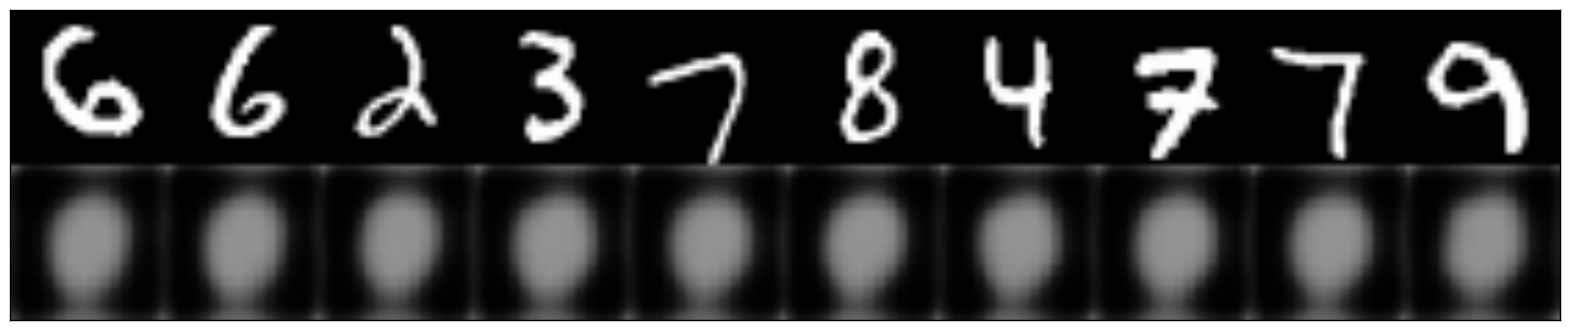

0


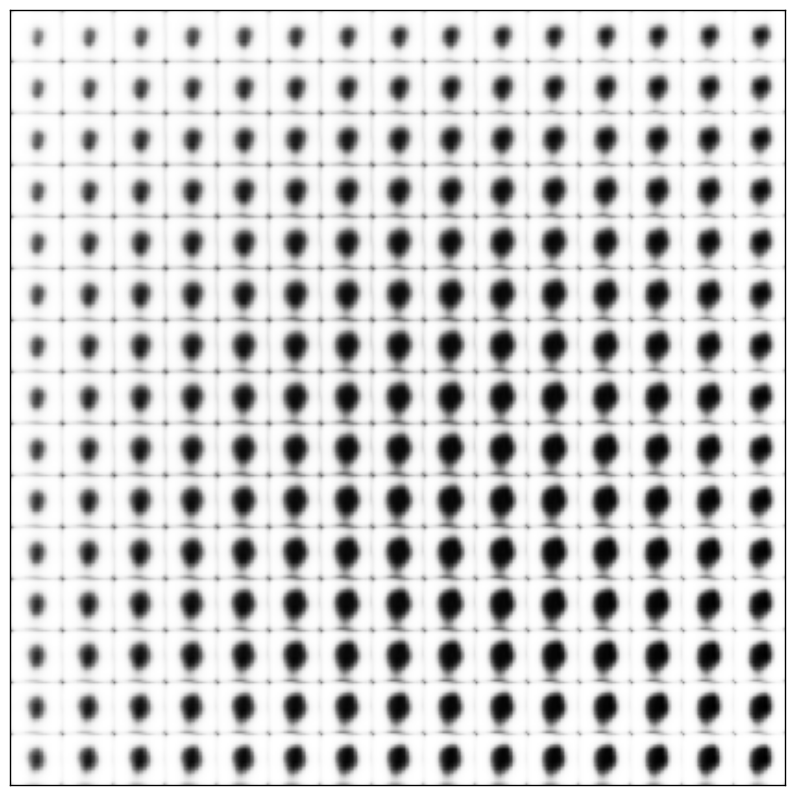

In [ ]:
batches_per_period = 20 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле

for i in range(5000):
    print('.', end='')
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = np.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

#     Шаги обучения генератора
    for j in range(k_step):
        l_d, l_e = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = np.random.randn(batch_size, latent_dim)

    # Периодическое рисование результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(l_d, l_e)

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, periods, c, fname, fig, batches_per_period): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys', norm=norm)
    plt.grid(None)
    plt.title("Label: {}\nBatch: {}".format(c, 0))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Label: {}\nBatch: {}".format(c, periods[i]*batches_per_period))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='imagemagick')

for label in range(num_classes):
    make_2d_figs_gif(figs[label], periods, label, "./figs4_5/manifold_{}.gif".format(label), plt.figure(figsize=(10,10)), batches_per_period)